In [1]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

/Users/adamerik/Documents/code/python/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/adamerik/Documents/code/python/venv/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [2]:
example = minds[0]
example

{'path': '/Users/adamerik/.cache/huggingface/datasets/downloads/extracted/d2743721f564501e682244dc99c3a548e18e1a5ed31f8dbc4f27bf5c33583738/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/Users/adamerik/.cache/huggingface/datasets/downloads/extracted/d2743721f564501e682244dc99c3a548e18e1a5ed31f8dbc4f27bf5c33583738/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [3]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [4]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [5]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/Users/adamerik/Documents/code/python/venv/lib/python3.9/site-packages/gradio/processing_utils.py:406: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


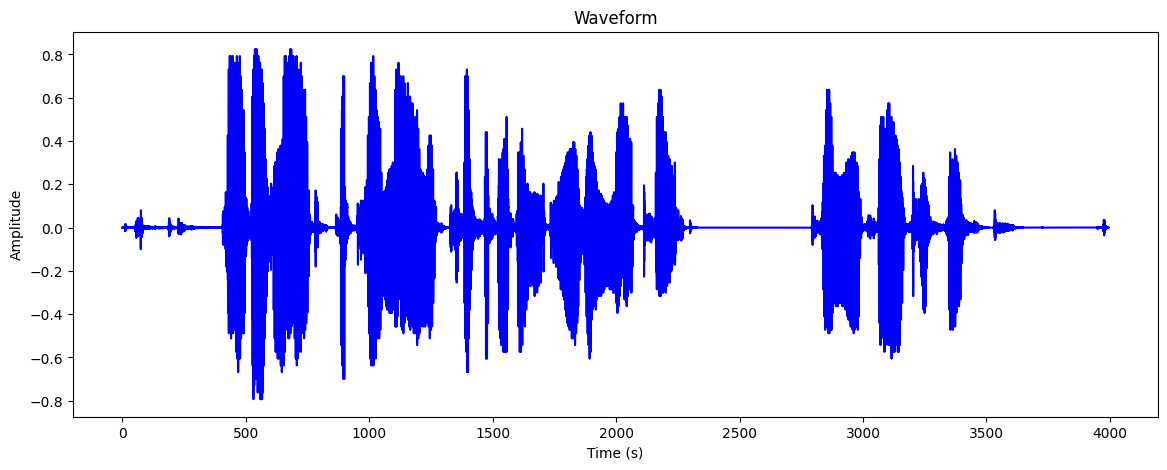

In [7]:
import librosa
import matplotlib.pyplot as plt

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

# Create the time axis
time = librosa.times_like(array, sr=sampling_rate)

# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(time, array, color='b')
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [8]:
sampling_rate

8000

In [9]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [10]:
minds[0]

{'path': '/Users/adamerik/.cache/huggingface/datasets/downloads/extracted/d2743721f564501e682244dc99c3a548e18e1a5ed31f8dbc4f27bf5c33583738/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/Users/adamerik/.cache/huggingface/datasets/downloads/extracted/d2743721f564501e682244dc99c3a548e18e1a5ed31f8dbc4f27bf5c33583738/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36116466e-05, 1.92324675e-04, 2.19285779e-04, ...,
         9.40909609e-04, 1.16613088e-03, 7.20880926e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [11]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [12]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [13]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [14]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [15]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

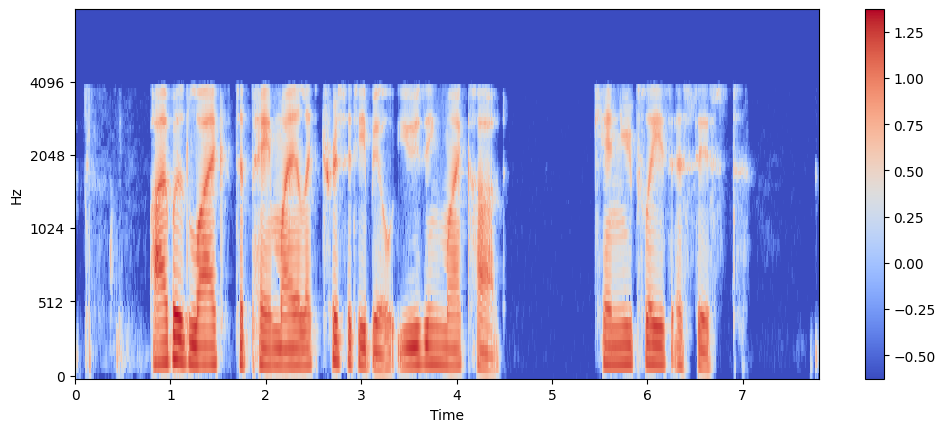

In [16]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()